# Extreme Multi-label Machine Model

This Jupyter Notebook goes over various methods of multi-label processing using heathcare data

In [ ]:
# Create environemnt if necessary
# conda create -n new environment --file req.txt
#conda install --file req.txt
#conda env update --file req.txt
#pip install -r req.txt
#pip install -U -r req.txt 
#conda create --name XML_LABEL --file req.txt

In [ ]:
# load data
from zipfile import ZipFile
from tqdm import tqdm
file_name = "data/data.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
 
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall(path='data')
    print('Done!')

### Baseline Machine Gaussian Naive Bayes Learning Model

In [ ]:
import hickle as hkl
X_train = hkl.load( 'data/X_train.hkl' )
X_test = hkl.load( 'data/X_test.hkl' )
y_test = hkl.load( 'data/y_test.hkl' )
y_train = hkl.load( 'data/y_train.hkl' )

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB

classif_list = []
train_score_list, test_score_list = [], []

# Training
print("Training")
for i in range(len(labels_list)):
    y_train_for_this_ub04 = y_train[:,i]
    new_classifier = GaussianNB()
    new_classifier.fit(X_train, y_train_for_this_ub04)
    classif_list.append(new_classifier)

# Test & display results
print("Test and display results")
for i in range(len(labels_list)):
    classif = classif_list[i]
    train_score = float('{0:.3f}'.format(classif.score(X_train, y_train[:,i])))
    test_score = float('{0:.3f}'.format(classif.score(X_test, y_test[:,i])))
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    print('Detecting {} with {}% accuracy (training {}%)'.format(labels_list[i], 100*test_score, 100*train_score))

predict_train = np.zeros_like(y_train)
predict_test = np.zeros_like(y_test)
for i in range(len(labels_list)):
    classif = classif_list[i]
    predict_train[:,i] = classif.predict(X_train)
    predict_test[:,i] = classif.predict(X_test)
acc_train = 1 - np.sum(np.abs(predict_train - y_train))/(y_train.shape[0]*y_train.shape[1])
acc_test = 1 - np.sum(np.abs(predict_test - y_test))/(y_test.shape[0]*y_test.shape[1])
print('###')
print('Global accuracy: testing {}, training {}'.format(acc_test, acc_train))

well_labeled = 0
for i in range(len(y_train)):
    if np.sum(np.abs(y_train[i,:] - predict_train[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} training samples were well labeled'.format(well_labeled,len(y_train)))

well_labeled = 0
for i in range(len(y_test)):
    if np.sum(np.abs(y_test[i,:] - predict_test[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))

# Evidemment, en plus d'être mathématiquement désapprouvée, cette méthode est encombrante:
# imaginez avoir à construire un million de classificateurs ! Ce n'est pas du tout extensible à de la classification extrême

### Deep Extreme Multi-label Learning by Zhang et al
Follwing XML methods in the paper [Deep Extreme Multi-label Learning by Zhang et al](https://arxiv.org/pdf/1704.03718.pdf) and [eXtreme Multilabel Classification Notebook](https://github.com/therhappy/xml-tuto/blob/master/eXtreme%20Multilabel%20Classification%20Notebook%20-%20EN.ipynb). 

![Machine Learning Path Image](https://github.com/Smone5/XML_EHR_LABELS/blob/master/images/labelmatrix.png "Machine Learning Path Image")

The goal in this section is build an embedded vector of the UB-04, ICD-10, CPT and Modifier labels. This embedded vector will be used to predict the correct label for EHR procedures.


#### Build Labels Embedded Graph
1. Load data
2. Deep Label Graph Embedding
3. Convert Label Edges to Embedded Vectors
4. Convert Features to Embedded Vectors

##### 1. Load data

In [28]:
import numpy as np
from tqdm import tqdm
import hickle as hkl
from scipy.sparse import csr_matrix
X_train = csr_matrix(hkl.load( 'data/X_train.hkl' ))
y_train = hkl.load( 'data/y_train.hkl' )
X_test = csr_matrix(hkl.load( 'data/X_test.hkl' ))
y_test = hkl.load( 'data/y_test.hkl' )
labels_list = hkl.load('data/labels_list.hkl' )

In [29]:
print("Training labels rows: ", y_train.shape[0])
print("Training lables columns: ", y_train.shape[1])

Training labels rows:  67000
Training lables columns:  8630


In [30]:
#example of labels in the first row that are activiated with a 1
np.where(y_train[0] == 1)

(array([ 282, 1914, 2423, 3781, 3794, 4486, 8285]),)

In [31]:
# Stack the training the test set in order to build the a network graph of labels
Y = np.vstack((y_train,y_test))

In [32]:
# just double check the output looks ok
np.where(Y[0] == 1)

(array([ 282, 1914, 2423, 3781, 3794, 4486, 8285]),)

The imported lables represent the decoded columns in Y labels

In [33]:
# view imported lables
print("First five labels: ", labels_list[0:5])
print("Representation of first five labels in Y: ", Y[0][0:5])

First five labels:  ['10022', '10060', '10120', '10160', '10180']
Representation of first five labels in Y:  [0 0 0 0 0]


In [34]:
print("Count of label names columns: ", len(labels_list))
print("Count of Y columns: ", Y.shape[1])

Count of label names columns:  8630
Count of Y columns:  8630


In [35]:
# view imported trianing labels
Y[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [36]:
#y_train = y_train[0:1000]
print("Labels training rows", Y.shape[0])
print("Labels training columns", Y.shape[1])

Labels training rows 100000
Labels training columns 8630


Note:
The label columns and training columns must be the same size to continue.

##### 2. Deep Label Graph Embedding
1. Build an edge list of the training labels
2. Input edge list into Deepwalk to convert to low-dimensional vectors

In [37]:
edges = [] # blank list to hold edges

In [38]:
%%time
# build training edges
for row in Y:
    act = list(np.where(row == 1))
    act = [list(i) for i in act ][0]
    for i in range(len(act)):
        for j in range(len(act)):
            #matrix[i,act[j]] +=1
            if i < j:
                edges.append([act[i],act[j]])
        

CPU times: user 9.31 s, sys: 3.05 s, total: 12.4 s
Wall time: 15.1 s


In [39]:
'''
# code for converting the numerical number back to original label for checking.
label_dict = {}
for i in range(len(labels_list)):
    label_dict[i] = labels_list[i]

for i in range(len(edges2)):
    val1 = edges2[i][0]
    val2 = edges2[i][1]
    edges2[i][0] = label_dict[val1]
    edges2[i][1] = label_dict[val2]
'''

'\n# code for converting the numerical number back to original label for checking.\nlabel_dict = {}\nfor i in range(len(labels_list)):\n    label_dict[i] = labels_list[i]\n\nfor i in range(len(edges2)):\n    val1 = edges2[i][0]\n    val2 = edges2[i][1]\n    edges2[i][0] = label_dict[val1]\n    edges2[i][1] = label_dict[val2]\n'

In [40]:
# convert train edges to edge list file for Deepwalk

import networkx as nx
G=nx.Graph()
for edge in tqdm(edges):
        G.add_edge(edge[0], edge[1])
        
# save as edge list file
with open('deepwalk/graphs/edges.edgelist', 'w') as f:
    for edge in tqdm(G.edges()):
        f.write("{} {}\n".format(edge[0] ,edge[1]))

100%|██████████| 362411/362411 [00:00<00:00, 382814.62it/s]


##### Analyze the graph in GraphCrunch 2 or Gephi
At this point you could visulize the graph in GraphCrunch 2 or Gephi
+ [GraphCrunch 2](http://www0.cs.ucl.ac.uk/staff/natasa/graphcrunch2/index.html)
+ [Paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-24)

There are a few methods to convert a network graph each node into a network as a low-dimensional feature vector.

1. [Deepwalk](https://github.com/phanein/deepwalk)
2. [Node2Vec](https://snap.stanford.edu/node2vec/)
3. [Struct2Vec](https://github.com/leoribeiro/struc2vec)
4. Graphlets

Due a paper from Shawn Gu and Tijana Milenković called [*Graphlets versus node2vec and struc2vec in the task of network alignment*](https://www.groundai.com/project/graphlets-versus-node2vec-and-struc2vec-in-the-task-of-network-alignment/), in certain situations a graphlet could outperform Node2Vec or Struct2Vec to quantify node similarities.

However due to time constraints, Deepwalk will be used in this method

*Note* :To use Deepwalk, you must use a Python 2.7 environment at the time of writing this

###### Deepwalk
To run Deepwalk you must run these line while in the folder *deepwalk*. This process can take a while.

deepwalk --input graphs/edges.edgelist --number-walks 150 --representation-size 300 --window-size 2 --workers 2 --output graphs/edges.embeddings

##### 4. Convert Features to Embedded Vectors

In [41]:
# load embeddings
import gensim
embedding =gensim.models.KeyedVectors.load_word2vec_format('deepwalk/graphs/edges.embeddings')

In [42]:
# load vectors from embeddings
V_embed = embedding.vectors

6464it [00:01, 4992.85it/s]


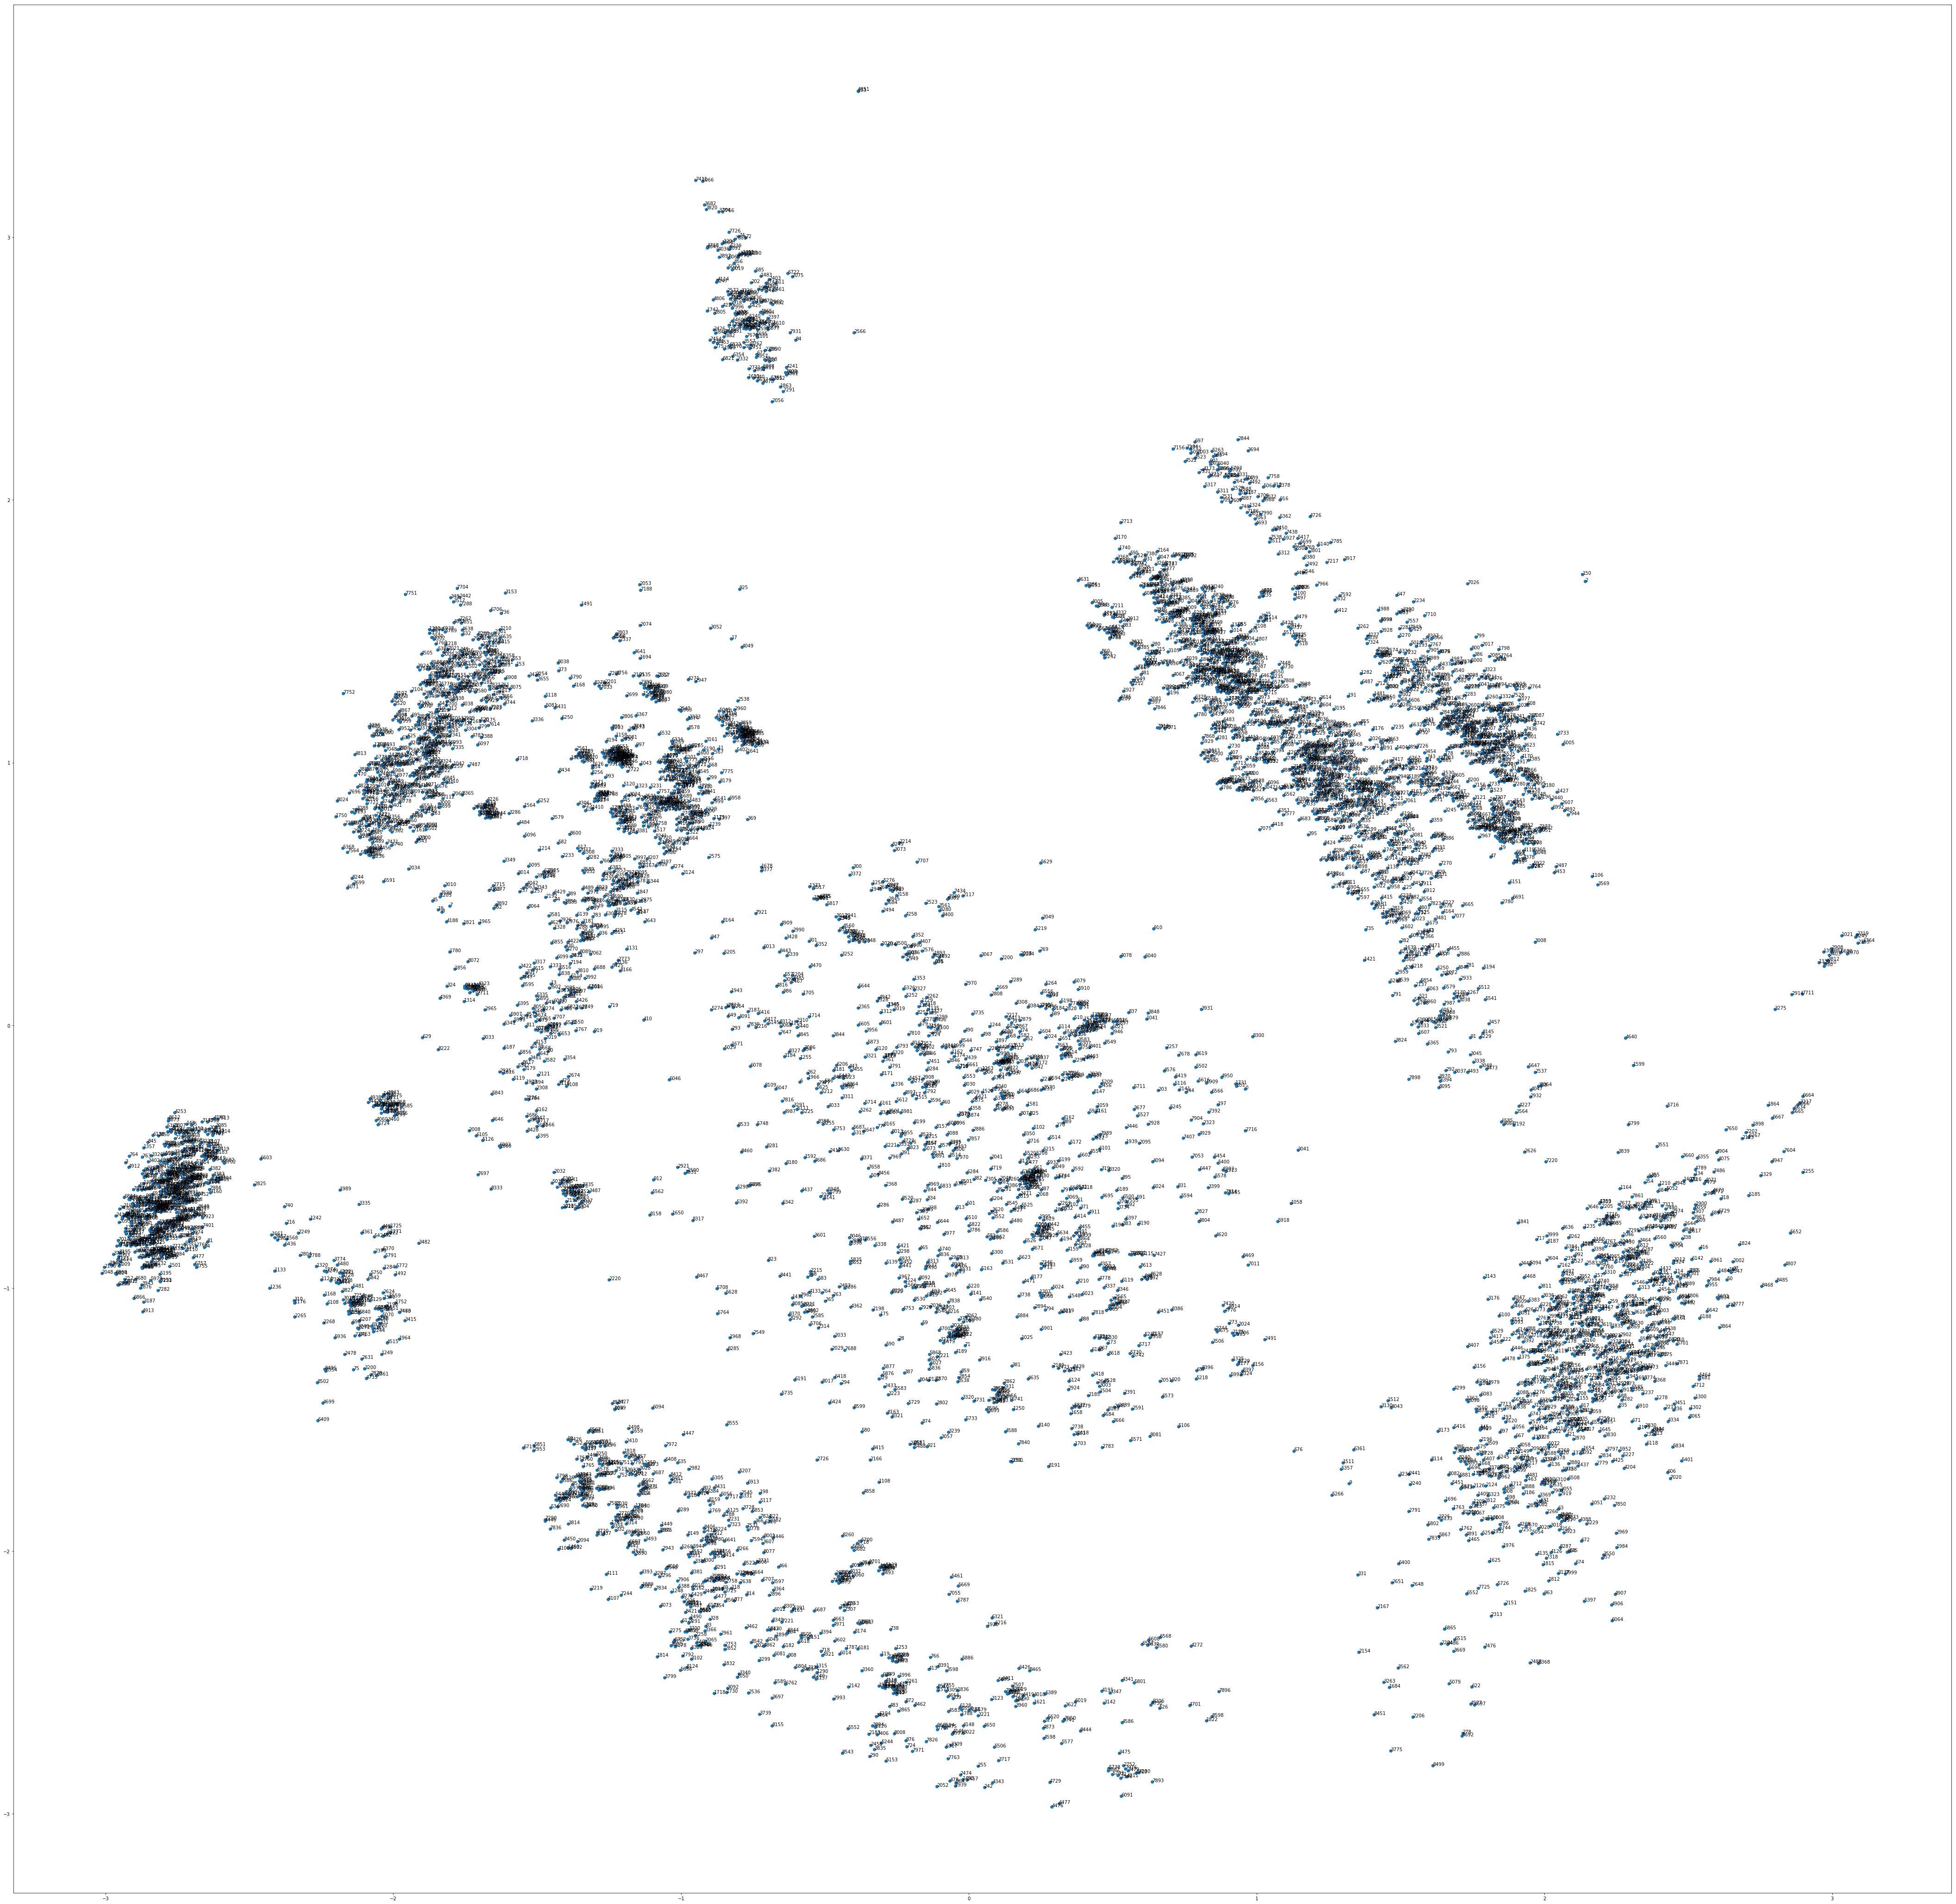

In [43]:
# Plot training embedded vectors into one dimensional graph

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

pca = PCA(n_components=2)
result = pca.fit_transform(V_embed)
# create a scatter plot of the projection
plt.figure(figsize=(75,75))
plt.scatter(result[:, 0], result[:, 1])
words = list(embedding.vocab)
for i, word in tqdm(enumerate(words)):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.savefig("images/PCA_graph.png")
plt.show()

Now we need to project the original label matrix to a new matrix including the embedded vectors.

In [44]:
print("Rows: ", V_embed.shape[0])
print("Columns: ",V_embed.shape[1])

Rows:  6464
Columns:  300


The embedded vector is 6,088 rows and 300 columns. Each row represents a node and its associated vectors. The orginal label matrix is 67,000 rows and 8,630 columns. Each rows represents a 1 if a label should exists or 0 if one doesn't.

In [45]:
import pandas as pd
labels_df = pd.DataFrame(data=y_train)
labels_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8620,8621,8622,8623,8624,8625,8626,8627,8628,8629
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Where each column has a 1, the column name gets assigned to that cell.
The column names are indexs of the activiations word2vec representation. In order to project the embedded graph to each row of the training data, the vectors activated in that row get multliplied together and then divided by 1/(number of non-zeros)

In [46]:
'''
Running this can be slow on some computers. To speed things up results are loaded in file


#Where each column has a 1, the column name gets assigned to that cell.
#The column names are indexs of word2vec representation
for col in labels_df:
    labels_df[col] = np.where(labels_df[col] != 0, col, 0)

fY = []
for index, row in tqdm(labels_df.iterrows()):
    #print(index)
    index_vals = np.where(labels_df.loc[index] > 0)[0].tolist()
    #print(index_vals)
    matrix = 1
    for val in index_vals:
        try:
            vector = embedding[str(val)]
            matrix = vector * matrix
        except KeyError:
            pass
        
    matrix = (1/len(index_vals))*matrix    
    fY.append(matrix)
'''

'\nRunning this can be slow on some computers. To speed things up results are loaded in file\n\n\n#Where each column has a 1, the column name gets assigned to that cell.\n#The column names are indexs of word2vec representation\nfor col in labels_df:\n    labels_df[col] = np.where(labels_df[col] != 0, col, 0)\n\nfY = []\nfor index, row in tqdm(labels_df.iterrows()):\n    #print(index)\n    index_vals = np.where(labels_df.loc[index] > 0)[0].tolist()\n    #print(index_vals)\n    matrix = 1\n    for val in index_vals:\n        try:\n            vector = embedding[str(val)]\n            matrix = vector * matrix\n        except KeyError:\n            pass\n        \n    matrix = (1/len(index_vals))*matrix    \n    fY.append(matrix)\n'

In [47]:
fY= hkl.load( 'data/fY.hkl' )

In [49]:
#fY[0]

In [85]:
from keras import backend as K

from keras.layers import Input
from keras import regularizers
features_input = Input(shape=(287,), dtype='float')

from keras.layers import Dense, Lambda, Dropout, BatchNormalization
from keras import optimizers

x = Dense(1024, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01))(features_input)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dropout(0.25)(x)
x = Dense(300, activation='linear')(x)
predictions = BatchNormalization()(x)


#l2 = Lambda(lambda x: K.l2_normalize(x, axis=1))(predictions)

from keras.models import Model
model = Model(inputs=features_input, outputs=predictions)

model.compile(optimizer=optimizers.Adam(lr=0.015, decay=0.0005),
              loss='mean_squared_error')


In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 287)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              294912    
_________________________________________________________________
fc2 (Dense)                  (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               307500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
Total params: 1,653,212
Trainable params: 1,652,612
Non-trainable params: 600
________________________________________________________________

In [87]:
print("Rows: ", X_train.shape[0])
print("Columns: ",X_train.shape[1])

Rows:  67000
Columns:  287


In [88]:
fY2 = np.asarray(fY)

In [89]:
print("Rows: ", fY2.shape[0])
print("Columns: ",fY2.shape[1])

Rows:  67000
Columns:  300


loss: 0.3210 - val_loss: 1.347 <br>
loss: 0.0018 - val_loss: 0.0019

In [90]:
'''
Train the deep neural network shown in Figure 1 to obtain
the mapping from original feature vector set X to embedded
feature vector set fX = { fx }
'''

model.fit(X_train, fY2, epochs=3, batch_size=32, validation_split=0.1, shuffle=True, class_weight='auto')

Train on 60300 samples, validate on 6700 samples
Epoch 1/3
60300/60300 [==============================] - 440s 7ms/step - loss: 0.0247 - val_loss: 0.0021
Epoch 2/3
60300/60300 [==============================] - 437s 7ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3/3
60300/60300 [==============================] - 437s 7ms/step - loss: 0.0018 - val_loss: 0.0020


In [91]:
fX = model.predict(X_train)

-0.39727506 <br>
-0.4063257

In [92]:
diff = np.sum(fY2[1] - fX[1])
diff

-0.5233601

In [93]:
'''
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k-means elbow method: The elbow method finds the optimal value for k (#clusters).
# https://pythonprogramminglanguage.com/kmeans-elbow-method/

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(fX)
    kmeanModel.fit(fX)
    distortions.append(sum(np.min(cdist(fX, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / fX.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\nfrom sklearn import metrics\nfrom scipy.spatial.distance import cdist\nimport matplotlib.pyplot as plt\n\n# k-means elbow method: The elbow method finds the optimal value for k (#clusters).\n# https://pythonprogramminglanguage.com/kmeans-elbow-method/\n\ndistortions = []\nK = range(1,20)\nfor k in K:\n    kmeanModel = KMeans(n_clusters=k).fit(fX)\n    kmeanModel.fit(fX)\n    distortions.append(sum(np.min(cdist(fX, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / fX.shape[0])\n\nplt.plot(K, distortions, 'bx-')\nplt.xlabel('k')\nplt.ylabel('Distortion')\nplt.title('The Elbow Method showing the optimal k')\nplt.show()\n"

In [94]:
from sklearn.cluster import KMeans
# create kmeans object
clusterings = []
for i in range(1):
    kmodel = KMeans(n_clusters=7, n_jobs=-1, n_init=8, max_iter=300)
    kmodel.fit(fX)
    clusterings.append(kmodel)

In [ ]:
import matplotlib.pyplot as plt
#  Partition fX into Z1, . . . ,Zm
Z = clusterings[0].fit_predict(fX)

# save new clusters for chart
plt.figure(figsize=(10,10))
plt.scatter(fX[:, 0], fX[:, 1], c=Z, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

### Prediction

In [95]:
fX_test = model.predict(X_test)

In [96]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2, metric='cosine')
knn.fit(fX, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [2]:
indexs_of_neighbors = knn.kneighbors(fX_test, n_neighbors=2, return_distance=False)

NameError: name 'knn' is not defined

In [1]:
indexs_of_neighbors[100]

NameError: name 'indexs_of_neighbors' is not defined

In [71]:
number_of_samples = indexs_of_neighbors.shape[0]
labels = np.zeros((number_of_samples, y_train.shape[1]))
for i in range(number_of_samples):
    for j in range(2):
        labels[i, :] += y_train[indexs_of_neighbors[i,j], :]
    for j in range(labels.shape[1]):
        if labels[i,j]: labels[i,j] = 1

In [79]:
print(labels[1])

[0. 0. 0. ... 0. 0. 0.]


In [80]:
np.count_nonzero(labels[1])

11

In [81]:
y_predict = labels

In [82]:
# Evaluate the full method precision
well_labeled = 0
for i in range(len(y_test)):
    if np.array_equal(y_test[i,:] , y_predict[i,:]):
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))

Overall 397 out of the 33000 testing samples were well labeled
